In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/fairness-variance


## Import dependencies

In [73]:
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from altair import datum
from IPython.display import display

from configs import config
from source.custom_classes.metrics_composer import MetricsComposer
from source.custom_classes.metrics_visualizer import MetricsVisualizer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [20]:
DATASET_NAME = "COMPAS_Without_Sensitive_Attributes"
SENSITIVE_ATTRIBUTES = ['sex', 'race', 'sex_race']
METRICS_PATH = os.path.join('results', 'hypothesis_space', 'COMPAS_Without_Sensitive_Attributes_Metrics_20230122__202033')
# MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG if 'MLPClassifier' not in model_config['model_name']]
MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG]
MODELS_NAMES

['DecisionTreeClassifier',
 'LogisticRegression',
 'RandomForestClassifier',
 'XGBClassifier',
 'KNeighborsClassifier',
 'MLPClassifier']

In [75]:
visualizer = MetricsVisualizer(METRICS_PATH, DATASET_NAME, MODELS_NAMES, SENSITIVE_ATTRIBUTES)

In [76]:
visualizer.models_average_metrics_dct[MODELS_NAMES[0]].head(20)

,Metric,Model_Name,overall,sex_race_priv,sex_race_dis,sex_priv,sex_dis,race_priv,race_dis
0,Accuracy,DecisionTreeClassifier,0.678504,0.674569,0.683459,0.686696,0.676589,0.667516,0.685796
1,Entropy,DecisionTreeClassifier,0.000000,0.000000,0.102105,0.000000,0.000000,0.000000,0.102042
2,F1,DecisionTreeClassifier,0.644673,0.500000,0.711204,0.584048,0.655816,0.513805,0.700574
3,FNR,DecisionTreeClassifier,0.359646,0.498750,0.275618,0.401948,0.352138,0.519766,0.285061
4,FPR,DecisionTreeClassifier,0.289515,0.241703,0.364118,0.261675,0.297157,0.224493,0.344890
5,General_Ensemble_Accuracy,DecisionTreeClassifier,0.678504,0.674569,0.683459,0.686696,0.676589,0.667516,0.685796
6,IQR,DecisionTreeClassifier,0.079647,0.099083,0.079440,0.085343,0.078320,0.081249,0.078579
7,Jitter,DecisionTreeClassifier,0.126178,0.141165,0.135251,0.137370,0.123571,0.112614,0.135109
8,Label_Stability,DecisionTreeClassifier,0.841477,0.821761,0.832061,0.826538,0.844960,0.856306,0.831742
9,Mean,DecisionTreeClassifier,0.523768,0.591160,0.470767,0.556273,0.516196,0.589017,0.481007


## Visualize average metrics

In [58]:
# Example of MetricsComposer usage
metrics_composer = MetricsComposer(SENSITIVE_ATTRIBUTES, visualizer.models_average_metrics_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,Metric,sex,race,sex_race
0,Equalized_Odds_TPR,0.049810,0.234705,0.223132
1,Equalized_Odds_FPR,0.035481,0.120397,0.122415
2,Disparate_Impact,0.930117,1.197647,0.999617
3,Statistical_Parity_Difference,-0.073331,0.171822,-0.000398
4,Accuracy_Parity,-0.010107,0.018280,0.008890
5,Label_Stability_Ratio,1.022289,0.971315,1.012534
6,IQR_Parity,-0.007023,-0.002670,-0.019644
7,Std_Parity,-0.007735,0.001301,-0.015313
8,Std_Ratio,0.896720,1.019184,0.819621
9,Jitter_Parity,-0.013798,0.022496,-0.005914


### Overall metrics visualizations

In [59]:
def overall_metric_comparison(prediction_metric_name, dataset_name, models_average_results_dct):
    comparison_df = pd.DataFrame(columns=('Dataset_Name', 'Metric_Name', 'Model_Name', 'Metric_Value'))
    for idx, model_name in enumerate(models_average_results_dct.keys()):
        model_average_results_df = models_average_results_dct[model_name]
        comparison_df.loc[idx] = [dataset_name, prediction_metric_name, model_name, model_average_results_df['overall'].loc[prediction_metric_name]]

    return comparison_df.sort_values(by=['Metric_Value'], ascending=False, axis=0)


def display_all_overall_metrics(dataset_name, model_names, models_average_results_dct):
    overall_metrics = list(models_average_results_dct[list(models_average_results_dct.keys())[0]].index)

    for overall_metric in overall_metrics:
        comparison_df = overall_metric_comparison(overall_metric, dataset_name, models_average_results_dct)
        print('#' * 30, f' {overall_metric} Comparison ', '#' * 30)
        display(comparison_df)

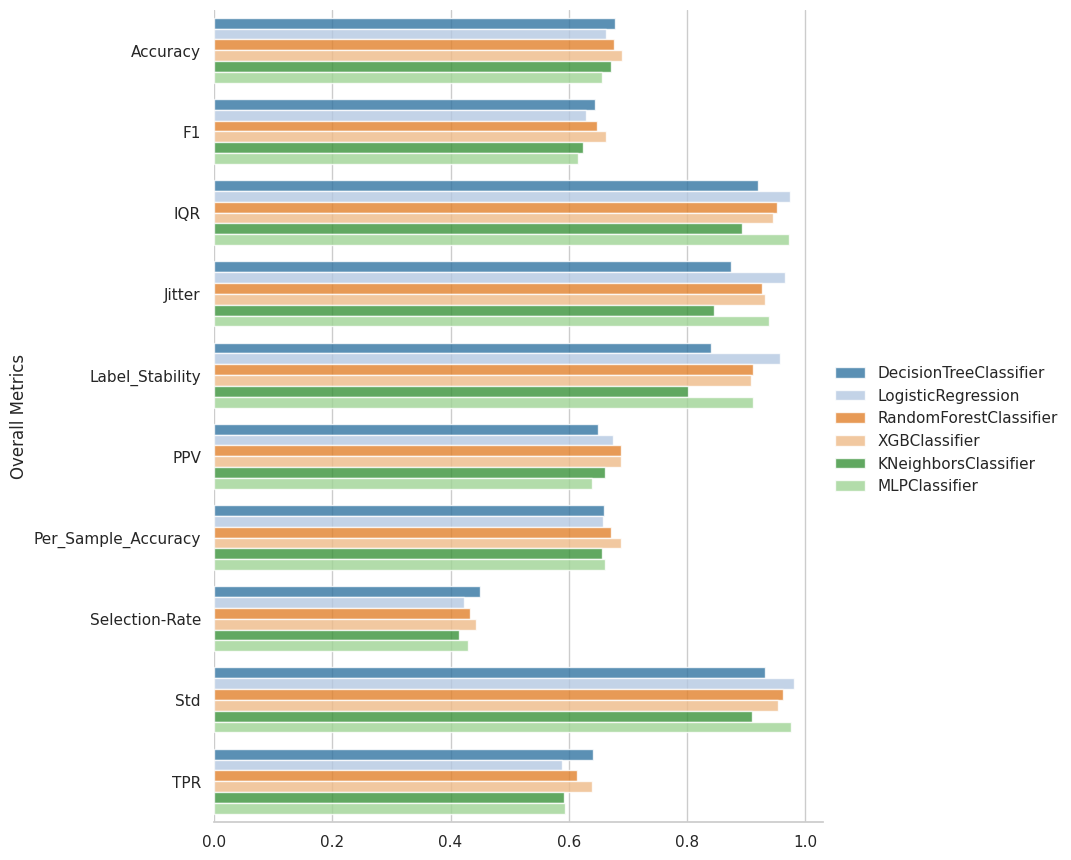

In [86]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                   'Per_Sample_Accuracy', 'Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Overall Metrics"
)

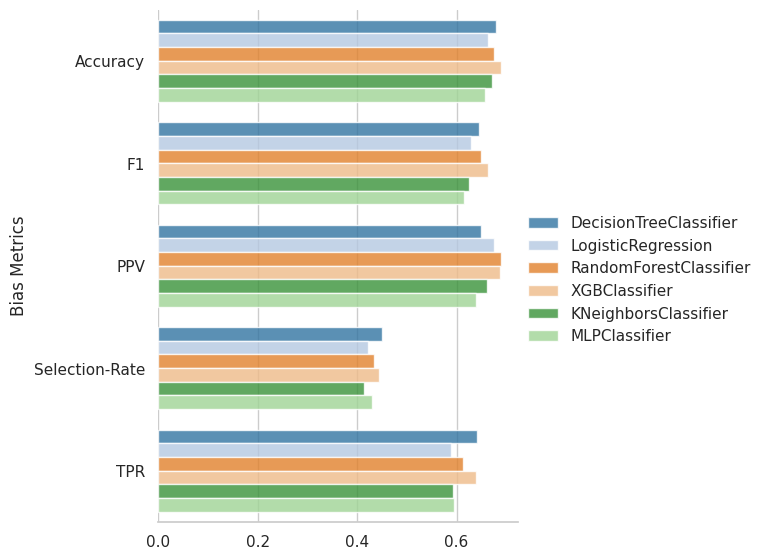

In [89]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
    x_label="Bias Metrics"
)

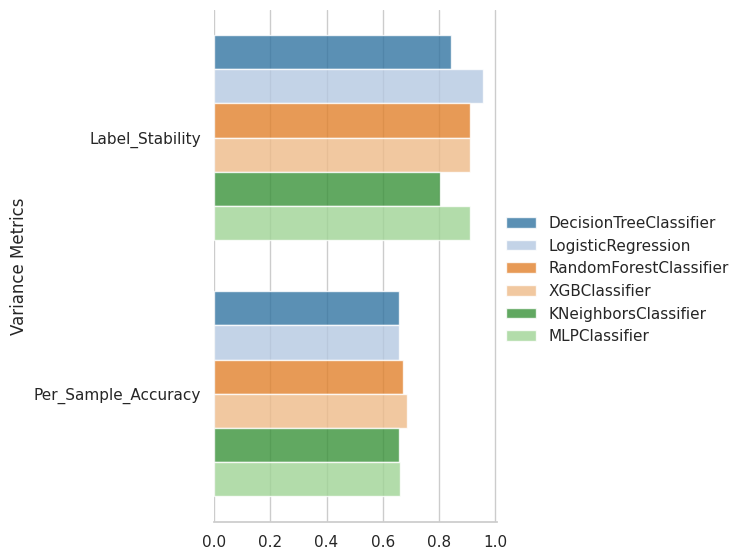

In [90]:
visualizer.visualize_overall_metrics(
    metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
    x_label="Variance Metrics"
)

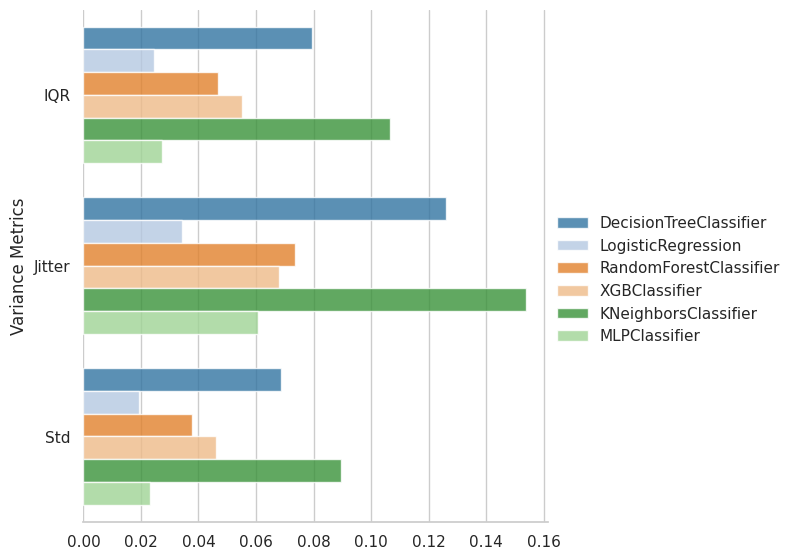

In [91]:
visualizer.visualize_overall_metrics(
    metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Variance Metrics"
)

In [92]:
visualizer.models_composed_metrics_df.head(20)

,Metric,sex,race,sex_race,Model_Name
0,Equalized_Odds_TPR,0.049810,0.234705,0.223132,DecisionTreeClassifier
1,Equalized_Odds_FPR,0.035481,0.120397,0.122415,DecisionTreeClassifier
2,Disparate_Impact,0.930117,1.197647,0.999617,DecisionTreeClassifier
3,Statistical_Parity_Difference,-0.073331,0.171822,-0.000398,DecisionTreeClassifier
4,Accuracy_Parity,-0.010107,0.018280,0.008890,DecisionTreeClassifier
5,Label_Stability_Ratio,1.022289,0.971315,1.012534,DecisionTreeClassifier
6,IQR_Parity,-0.007023,-0.002670,-0.019644,DecisionTreeClassifier
7,Std_Parity,-0.007735,0.001301,-0.015313,DecisionTreeClassifier
8,Std_Ratio,0.896720,1.019184,0.819621,DecisionTreeClassifier
9,Jitter_Parity,-0.013798,0.022496,-0.005914,DecisionTreeClassifier


In [33]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                visualizer.create_models_metrics_bar_chart(bias_metrics_lst, metrics_group_name="Bias")

In [34]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                visualizer.create_models_metrics_bar_chart(variance_metrics_lst, metrics_group_name="Variance")

In [35]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300, title="Bias Metric Plot"),
        models_variance_metrics_chart.properties(height=200, width=300, title="Variance Metric Plot"),
    )
)

alt.HConcatChart(...)

In [77]:
models_average_results_df = visualizer.all_models_metrics_df

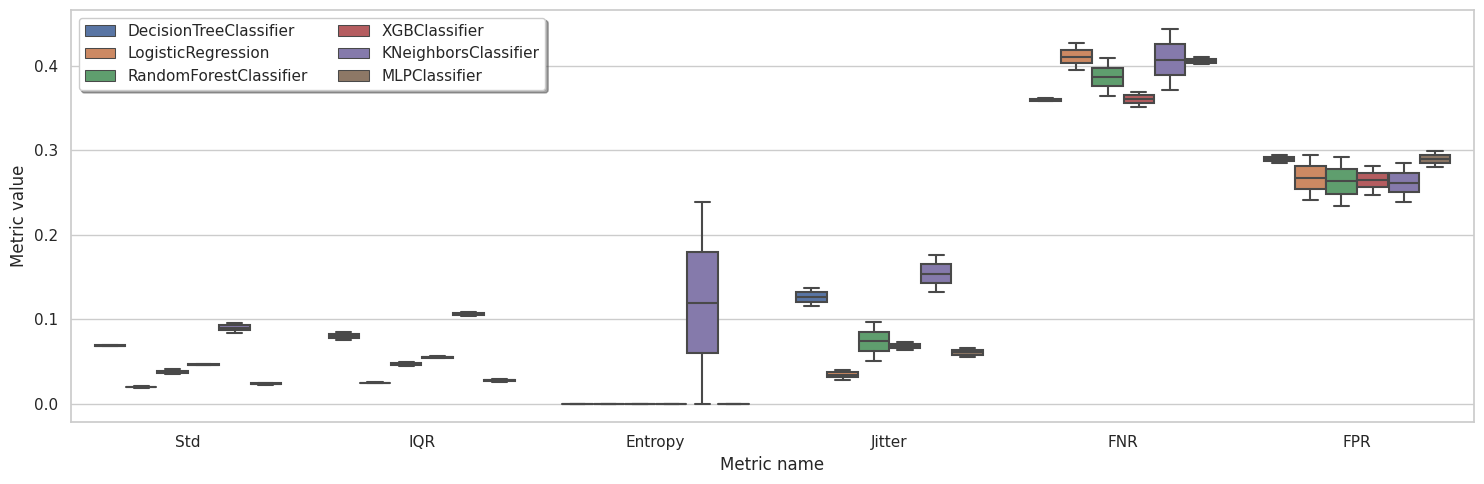

In [79]:
to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Std', 'IQR', 'Entropy', 'Jitter', 'FNR','FPR'])]

plt.figure(figsize=(15, 5))


sns.boxplot(x = to_plot['Metric'],
            y = to_plot['overall'],
            hue= to_plot['Model_Name'],
            #order=['Accuracy']
            #order=['Accuracy','TNR','TPR','FNR','FPR','Selection-Rate']
           )

plt.legend(loc='upper left',
          ncol=2, fancybox=True, shadow=True)
plt.xlabel("Metric name")
plt.ylabel("Metric value")
#plt.ylim(0,1)
#plt.title("Peformance on overall test set: "+experiment)

plt.tight_layout()

#plt.savefig(filename+'_overall.png', bbox_inches='tight')

In [80]:
sorted_models_composed_metrics_df = visualizer.melted_models_composed_metrics_df.sort_values(by=['Value'])

In [81]:
set(sorted_models_composed_metrics_df.Metric)

{'Accuracy_Parity',
 'Disparate_Impact',
 'Equalized_Odds_FPR',
 'Equalized_Odds_TPR',
 'IQR_Parity',
 'Jitter_Parity',
 'Label_Stability_Ratio',
 'Statistical_Parity_Difference',
 'Std_Parity',
 'Std_Ratio'}

In [82]:
def color_df(val):
    if val is 'RandomForestClassifier':
        color = 'pink' 
    if val is 'LogisticRegression':
        color = 'yellow'
    if val is 'DecisionTreeClassifier':
        color = 'cyan'
    if val is 'XGBClassifier':
        color = 'green'
    if val is 'KNeighborsClassifier':
        color = 'orange'
    if val is 'MLPClassifier':
        color = 'purple'
    return 'background-color: %s' % color

In [83]:
results = {}

for metric in ['Disparate_Impact','Label_Stability_Ratio']:
    for subgroup in ['sex','race','sex_race']:
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values
        
#pd.DataFrame(results).T
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4,5
Disparate_Impact_sex,XGBClassifier,DecisionTreeClassifier,MLPClassifier,RandomForestClassifier,LogisticRegression,KNeighborsClassifier
Disparate_Impact_race,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,MLPClassifier,LogisticRegression
Disparate_Impact_sex_race,DecisionTreeClassifier,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,MLPClassifier,LogisticRegression
Label_Stability_Ratio_sex,KNeighborsClassifier,RandomForestClassifier,LogisticRegression,MLPClassifier,DecisionTreeClassifier,XGBClassifier
Label_Stability_Ratio_race,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,MLPClassifier,XGBClassifier
Label_Stability_Ratio_sex_race,KNeighborsClassifier,RandomForestClassifier,LogisticRegression,MLPClassifier,DecisionTreeClassifier,XGBClassifier


In [84]:
results = {}

for metric in ['Accuracy_Parity','Equalized_Odds_FPR','Statistical_Parity_Difference','IQR_Parity','Jitter_Parity','Std_Parity']:
    for subgroup in ['sex','race','sex_race']:
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values

        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4,5
Accuracy_Parity_sex,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression,MLPClassifier
Accuracy_Parity_race,MLPClassifier,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,XGBClassifier,LogisticRegression
Accuracy_Parity_sex_race,RandomForestClassifier,KNeighborsClassifier,XGBClassifier,DecisionTreeClassifier,LogisticRegression,MLPClassifier
Equalized_Odds_FPR_sex,DecisionTreeClassifier,MLPClassifier,XGBClassifier,LogisticRegression,RandomForestClassifier,KNeighborsClassifier
Equalized_Odds_FPR_race,XGBClassifier,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,MLPClassifier
Equalized_Odds_FPR_sex_race,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,MLPClassifier,RandomForestClassifier
Statistical_Parity_Difference_sex,XGBClassifier,DecisionTreeClassifier,MLPClassifier,RandomForestClassifier,LogisticRegression,KNeighborsClassifier
Statistical_Parity_Difference_race,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,MLPClassifier,LogisticRegression
Statistical_Parity_Difference_sex_race,DecisionTreeClassifier,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,MLPClassifier
IQR_Parity_sex,DecisionTreeClassifier,XGBClassifier,MLPClassifier,LogisticRegression,KNeighborsClassifier,RandomForestClassifier
